In [79]:
#importing the necessary libraries
import numpy as np
import tensorflow as tf
import keras
import os
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [46]:
#making image and mask lists from the kaggle dataset
image_list = os.listdir('heat_sink_defect_detection/Heat_Sink_Surface_Defect_Dataset/images')
mask_list = os.listdir('heat_sink_defect_detection/Heat_Sink_Surface_Defect_Dataset/labels')
image_list = ['heat_sink_defect_detection/Heat_Sink_Surface_Defect_Dataset/images/'+i for i in image_list]
mask_list = ['heat_sink_defect_detection/Heat_Sink_Surface_Defect_Dataset/labels/'+i for i in mask_list]

Text(0.5, 1.0, 'Mask')

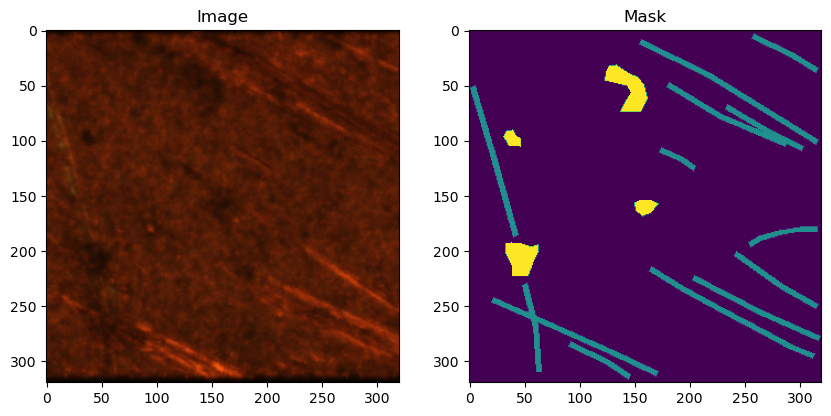

In [49]:
N = 100 #no. of images to read
img = imageio.v3.imread(image_list[N])
mask = imageio.v3.imread(mask_list[N])

#plotting image and corresponding mask
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

In [76]:
mask_mat = np.zeros([320, 320, 1000])         
for i, mask in enumerate(mask_list):
    m = tf.io.read_file(mask)                 #reading mask png files
    m = tf.image.decode_png(m, channels=3)    #decoding png to tensor
    mask_mat[:, :, i] = tf.squeeze(tf.math.reduce_max(m, axis=-1, keepdims=True)) #dimensionality reduction of tensor
    
y = np.unique(mask_mat, return_counts = True)

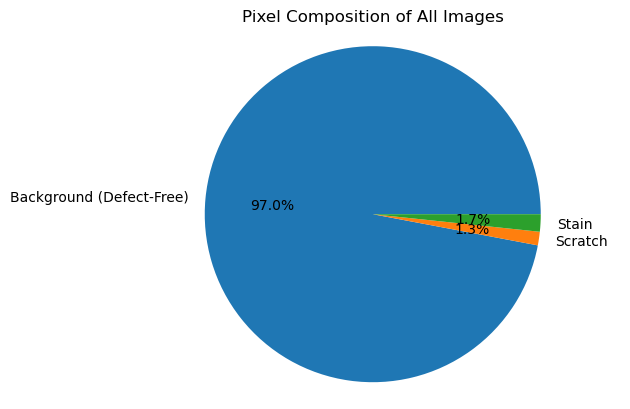

In [77]:
labels = 'Background (Defect-Free)', 'Scratch', 'Stain'
sizes = [99357441, 1333995, 1708564]    #obtained from values from above calculation

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')

ax1.set_title("Pixel Composition of All Images")

plt.show()

In [78]:
mask_mat_re = np.reshape(mask_mat, (-1, 1000)) #reshaped the last dimension of dataset

mask_unique = []

for i in range(1000):
    mask_unique.append(tuple(set(mask_mat_re[:, i])))
    
Counter(mask_unique)

#(0.0, 1.0, 2.0) represent heat sink with scratch and stains
#(0.0, 2.0) represent heat sink with stains
#(0.0, 1.0) represent heat sink with scratches

Counter({(0.0, 1.0, 2.0): 672, (0.0, 2.0): 300, (0.0, 1.0): 28})

In [54]:
x_train, x_test, y_train, y_test = train_test_split(image_list,mask_list,test_size=0.3,random_state=30)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=30)
#dataset is split into 70:15:15 (train:val:test)

In [55]:
#converting all splits to a constant tensor
image_train = tf.constant(x_train)
masks_train =  tf.constant(y_train)
image_val = tf.constant(x_val)
masks_val = tf.constant(y_val)
image_test = tf.constant(x_test)
masks_test = tf.constant(y_test)

In [56]:
#preparation of dataset by merging image and masks of corresponding splits
dataset_train = tf.data.Dataset.from_tensor_slices((image_train,masks_train))
dataset_val = tf.data.Dataset.from_tensor_slices((image_val, masks_val))
dataset_test = tf.data.Dataset.from_tensor_slices((image_test, masks_test))

In [14]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)                         #reading the image file path
    img = tf.image.decode_bmp(img, channels=3)                #conversion of bmp to tensor
    img = tf.image.convert_image_dtype(img, tf.float32)       #converting tensor to image

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  #dimension reduction
    return img, mask

def preprocess(image, mask):
    #resizing image and masks
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')
    return input_image, input_mask

#applying the above functions to train,val and test datasets
processed_ds_train = dataset_train.map(process_path).map(preprocess)
processed_ds_val = dataset_val.map(process_path).map(preprocess)
processed_ds_test = dataset_test.map(process_path).map(preprocess)

## U-Net

## Contracting Block

In [18]:
#architecture for contracting block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
    else:
        next_layer = conv
    
    skip_connection = conv
    
    return next_layer, skip_connection

## Upsampling block

In [20]:
#architecture for upsampling block
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [21]:
#adding the model blocks
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=3):

    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 16*n_filters, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  4*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [22]:
unet = unet_model((256, 256, 3), n_filters=32, n_classes=3)
unet.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                         

 conv2d_17 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_16[0][0]']           
                                                                                                  
 conv2d_18 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_17[0][0]']           
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 3)          99        ['conv2d_18[0][0]']           
                                                                                                  
Total params: 8639811 (32.96 MB)
Trainable params: 8639811 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [23]:
unet.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy']
            )

In [57]:
train_dataset = processed_ds_train.batch(32)
# model_history = unet.fit(train_dataset, epochs=10)
# plt.plot(model_history.history["accuracy"])


#train and save model to avoid any training time for future use

In [61]:
# unet.save('model_1.h5')
unet = tf.keras.models.load_model('model_1.h5')

In [28]:
import segmentation_models as sm #importing pre-trained models

In [26]:
#if the above code block produces error, run this cell
import os            
os.environ["SM_FRAMEWORK"] = "tf.keras"

## Resnet50

In [29]:
BACKBONE1 = 'resnet50'       #resnet50 model

resnet50_BB = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=3) #pre defined weights

resnet50_BB.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(resnet50_BB.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

                                                                                                  
 stage1_unit2_conv3 (Conv2D  (None, None, None, 256)      16384     ['stage1_unit2_relu3[0][0]']  
 )                                                                                                
                                                                                                  
 add_1 (Add)                 (None, None, None, 256)      0         ['stage1_unit2_conv3[0][0]',  
                                                                     'add[0][0]']                 
                                                                                                  
 stage1_unit3_bn1 (BatchNor  (None, None, None, 256)      1024      ['add_1[0][0]']               
 malization)                                                                                      
                                                                                                  
 stage1_un

                                                                                                  
 stage2_unit2_bn2 (BatchNor  (None, None, None, 128)      512       ['stage2_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage2_unit2_relu2 (Activa  (None, None, None, 128)      0         ['stage2_unit2_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, None, None, 128)      0         ['stage2_unit2_relu2[0][0]']  
 ing2D)                                                                                           
                                                                                                  
 stage2_un

 tion)                                                                                            
                                                                                                  
 stage2_unit4_conv3 (Conv2D  (None, None, None, 512)      65536     ['stage2_unit4_relu3[0][0]']  
 )                                                                                                
                                                                                                  
 add_6 (Add)                 (None, None, None, 512)      0         ['stage2_unit4_conv3[0][0]',  
                                                                     'add_5[0][0]']               
                                                                                                  
 stage3_unit1_bn1 (BatchNor  (None, None, None, 512)      2048      ['add_6[0][0]']               
 malization)                                                                                      
          

 )                                                                                                
                                                                                                  
 stage3_unit3_bn2 (BatchNor  (None, None, None, 256)      1024      ['stage3_unit3_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage3_unit3_relu2 (Activa  (None, None, None, 256)      0         ['stage3_unit3_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_11 (ZeroPad  (None, None, None, 256)      0         ['stage3_unit3_relu2[0][0]']  
 ding2D)                                                                                          
          

 stage3_unit5_relu3 (Activa  (None, None, None, 256)      0         ['stage3_unit5_bn3[0][0]']    
 tion)                                                                                            
                                                                                                  
 stage3_unit5_conv3 (Conv2D  (None, None, None, 1024)     262144    ['stage3_unit5_relu3[0][0]']  
 )                                                                                                
                                                                                                  
 add_11 (Add)                (None, None, None, 1024)     0         ['stage3_unit5_conv3[0][0]',  
                                                                     'add_10[0][0]']              
                                                                                                  
 stage3_unit6_bn1 (BatchNor  (None, None, None, 1024)     4096      ['add_11[0][0]']              
 malizatio

 stage4_unit2_conv1 (Conv2D  (None, None, None, 512)      1048576   ['stage4_unit2_relu1[0][0]']  
 )                                                                                                
                                                                                                  
 stage4_unit2_bn2 (BatchNor  (None, None, None, 512)      2048      ['stage4_unit2_conv1[0][0]']  
 malization)                                                                                      
                                                                                                  
 stage4_unit2_relu2 (Activa  (None, None, None, 512)      0         ['stage4_unit2_bn2[0][0]']    
 tion)                                                                                            
                                                                                                  
 zero_padding2d_16 (ZeroPad  (None, None, None, 512)      0         ['stage4_unit2_relu2[0][0]']  
 ding2D)  

 decoder_stage0b_bn (BatchN  (None, None, None, 256)      1024      ['decoder_stage0b_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage0b_relu (Acti  (None, None, None, 256)      0         ['decoder_stage0b_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage1_upsampling   (None, None, None, 256)      0         ['decoder_stage0b_relu[0][0]']
 (UpSampling2D)                                                                                   
                                                                                                  
 decoder_stage1_concat (Con  (None, None, None, 768)      0         ['decoder_stage1_upsampling[0]
 catenate)

                                                                                                  
 decoder_stage4a_conv (Conv  (None, None, None, 16)       4608      ['decoder_stage4_upsampling[0]
 2D)                                                                [0]']                         
                                                                                                  
 decoder_stage4a_bn (BatchN  (None, None, None, 16)       64        ['decoder_stage4a_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 decoder_stage4a_relu (Acti  (None, None, None, 16)       0         ['decoder_stage4a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_s

In [30]:
train_dataset_batchsize16 = processed_ds_train.batch(32)
history1 = resnet50_BB.fit(train_dataset_batchsize16, epochs=1)
#epoch is set to 1, due to low computational power
#users can increase the no. of epochs to 40 for good accuracy

D:\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(




22/22 [==============================] - 1108s 49s/step - loss: 0.5129 - accuracy: 0.8513


In [31]:
resnet50_BB.save('resnet_model.h5') #save the model for future use

D:\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
def display(display_list):            #function for comparing input,true and predicted image
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis] # (...) represents all the axes before the new axis
    return pred_mask[0]

def show_predictions(dataset=None, num=1, model = unet):  #function for comparing input,true and predicted image
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

## Vgg16

In [33]:
BACKBONE2 = 'vgg16' #pre trained model

vgg16_BB = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=3) #pre trained weights on imagenet

vgg16_BB.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(vgg16_BB.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                                                                                            

                                                                                                  
 decoder_stage1_upsampling   (None, None, None, 256)      0         ['decoder_stage0b_relu[0][0]']
 (UpSampling2D)                                                                                   
                                                                                                  
 decoder_stage1_concat (Con  (None, None, None, 768)      0         ['decoder_stage1_upsampling[0]
 catenate)                                                          [0]',                         
                                                                     'block4_conv3[0][0]']        
                                                                                                  
 decoder_stage1a_conv (Conv  (None, None, None, 128)      884736    ['decoder_stage1_concat[0][0]'
 2D)                                                                ]                             
          

 ormalization)                                                                                    
                                                                                                  
 decoder_stage4a_relu (Acti  (None, None, None, 16)       0         ['decoder_stage4a_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 decoder_stage4b_conv (Conv  (None, None, None, 16)       2304      ['decoder_stage4a_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 decoder_stage4b_bn (BatchN  (None, None, None, 16)       64        ['decoder_stage4b_conv[0][0]']
 ormalization)                                                                                    
          

In [34]:
history2 = vgg16_BB.fit(train_dataset_batchsize16, epochs=1)
#epoch is set to 1, due to low computational power
#users can increase the no. of epochs to 40 for good accuracy

22/22 [==============================] - 510s 22s/step - loss: 0.4795 - accuracy: 0.9011


In [35]:
vgg16_BB.save('vgg16_BB_batch16.h5') #saving the model

In [63]:
test_dataset = processed_ds_test.batch(32) #seperated into batches of size 32

In [ ]:
resnet50_BB.evaluate(test_dataset, batch_size = 32, verbose = True) #for evaluating the model accuracy 

In [ ]:
show_predictions(train_dataset, 1)

In [67]:
val_real_image = np.empty([0, 256, 256, 3])
val_real_mask = np.empty([0, 256, 256, 1])

for img, mask in val_dataset:
    val_real_image = np.append(val_real_image, img, axis = 0)
    val_real_mask = np.append(val_real_mask, mask, axis = 0)

val_real_mask_sq = np.reshape(np.squeeze(val_real_mask), (val_real_mask.shape[0], -1))


In [80]:
val_results = np.argmax(unet.predict(val_dataset), axis=-1) #axis=-1 represents the last axis
val_results = val_results[..., tf.newaxis]
val_results_sq = np.reshape(np.squeeze(val_results), (val_results.shape[0], -1))


5/5 [==============================] - 18s 3s/step


In [ ]:
#code for obtaining confusion matrix for the required model
#confusion matrix can be changed by changing unet.predict with (required model).predict
cm = confusion_matrix(val_real_mask_sq.reshape(-1), val_results_sq.reshape(-1))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm_df = pd.DataFrame(cmn,index = ['No Defect','Scratch','Stain'], columns = ['No Defect','Scratch','Stain'])

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='.2%', annot_kws={"size": 20})
plt.ylabel('Actual')
plt.xlabel('Predicted')